In [1]:
import pandas as pd
from tech_core.feature_pipeline import FeaturesPipeline
from tech_core.losses import StreamingSharpeLoss
from tech_core.nn_builder import SimplePortfolioAllocator, DeepPortfolioAllocator_1
import torch
from tqdm import tqdm

In [2]:
path_to_data = '../data/'

split_dates = [
    pd.Timestamp("2025-01-01")
]
split_names = ['train', 'test']

padding = 35
batch_size_config = {
    0: 1000,
    # 40: 4000,
    # 80: 10000
}
num_epochs = 1000
adam_lr = 1e-2
log_freq = 10

Loading features: 0it [00:00, ?it/s]


cmf_dim: 126, asset_dim: 5, num_assets: 488


  0%|          | 0/1000 [00:00<?, ?it/s]

Changing batch size to 1000 at epoch 0


  1%|          | 9/1000 [08:23<14:53:10, 54.08s/it]

Sharpe Ratio for the epoch: 15.2402
Average Weights:



,Weight
Cash,9.105255e-01
BKNG,2.983848e-02
FICO,1.343623e-02
NVR,1.261176e-02
MPWR,1.062922e-02
...,...
LYB,1.096143e-08
DOW,1.002836e-08
ROST,9.926182e-09
ALB,9.569538e-09


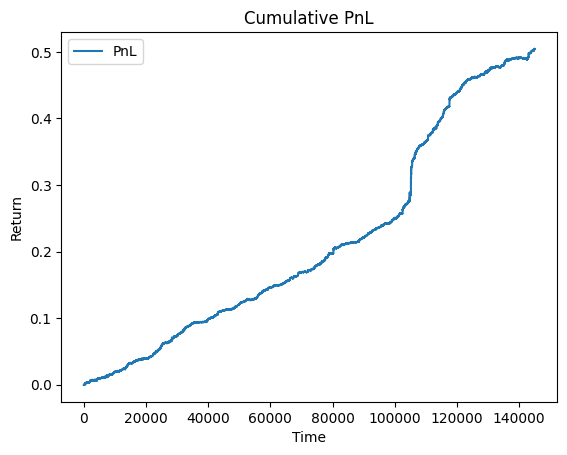

Sharpe Ratio for the epoch: 18.4004
Average Weights:



,Weight
Cash,8.785520e-01
BKNG,5.651756e-02
FICO,2.103272e-02
NVR,1.468758e-02
AZO,1.217493e-02
...,...
LYB,5.381304e-09
DOW,4.898480e-09
ROST,4.833870e-09
ALB,4.641155e-09


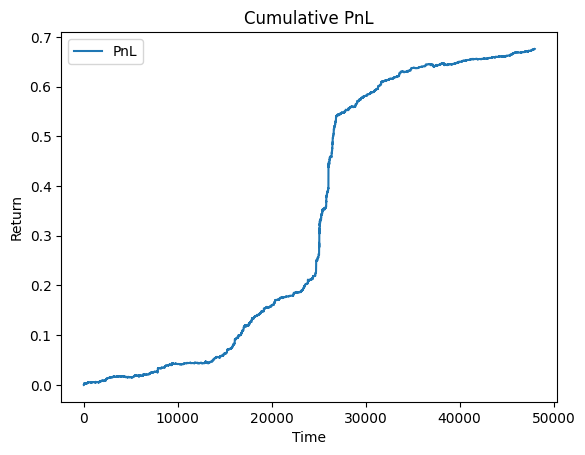

  2%|▏         | 19/1000 [17:47<15:21:54, 56.39s/it]

Sharpe Ratio for the epoch: 25.8899
Average Weights:



,Weight
Cash,8.313296e-01
BKNG,5.656674e-02
FICO,2.594500e-02
MPWR,2.215998e-02
NVR,2.206076e-02
...,...
LYB,1.089261e-11
DOW,9.395065e-12
ROST,9.243822e-12
ALB,8.701327e-12


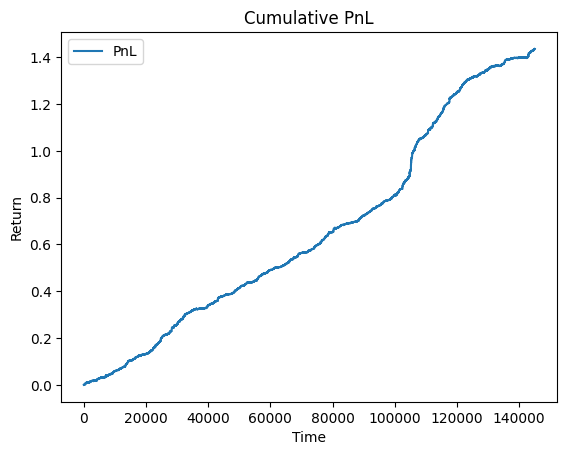

Sharpe Ratio for the epoch: 24.7746
Average Weights:



,Weight
Cash,7.919395e-01
BKNG,7.633723e-02
FICO,4.831827e-02
AZO,3.331793e-02
NVR,2.160056e-02
...,...
LYB,7.992731e-12
DOW,6.888093e-12
ROST,6.753107e-12
ALB,6.336346e-12


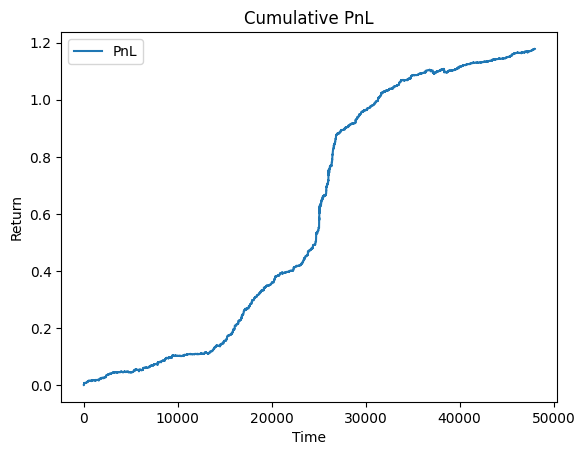

  3%|▎         | 29/1000 [27:10<14:39:33, 54.35s/it]

Sharpe Ratio for the epoch: 29.1437
Average Weights:



,Weight
Cash,7.945338e-01
BKNG,6.759696e-02
FICO,3.082004e-02
NVR,2.842003e-02
MPWR,2.747937e-02
...,...
LYB,5.830200e-13
DOW,4.887722e-13
ROST,4.794729e-13
ALB,4.461497e-13


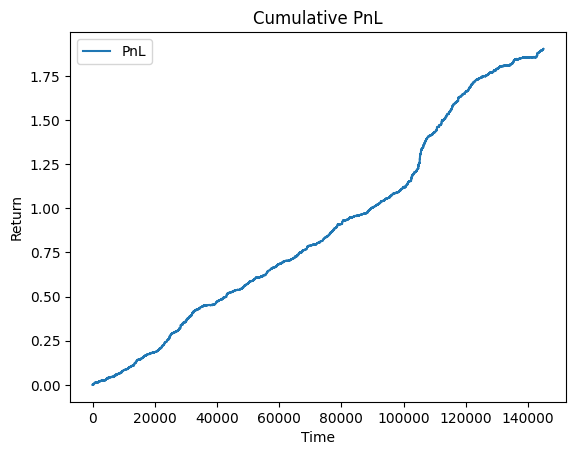

Sharpe Ratio for the epoch: 26.0632
Average Weights:



,Weight
Cash,7.578208e-01
BKNG,8.504760e-02
FICO,5.860876e-02
AZO,4.525436e-02
NVR,2.380694e-02
...,...
LYB,4.496604e-13
DOW,3.770353e-13
ROST,3.684625e-13
ALB,3.417844e-13


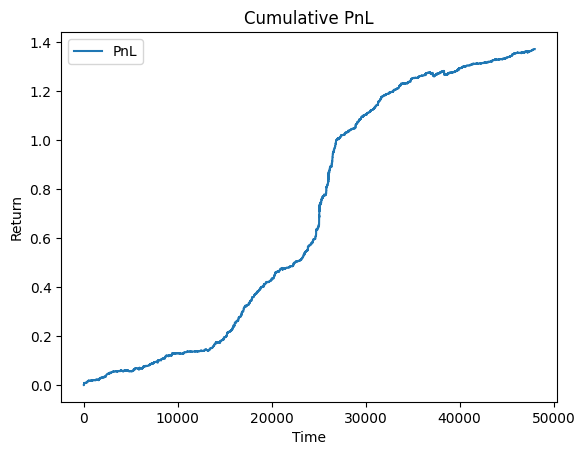

  4%|▍         | 39/1000 [36:39<15:55:51, 59.68s/it]

Sharpe Ratio for the epoch: 30.6738
Average Weights:



,Weight
Cash,7.730516e-01
BKNG,7.381669e-02
FICO,3.400815e-02
NVR,3.281845e-02
AZO,3.013976e-02
...,...
LYB,8.925656e-14
DOW,7.340489e-14
ROST,7.186539e-14
ALB,6.635208e-14


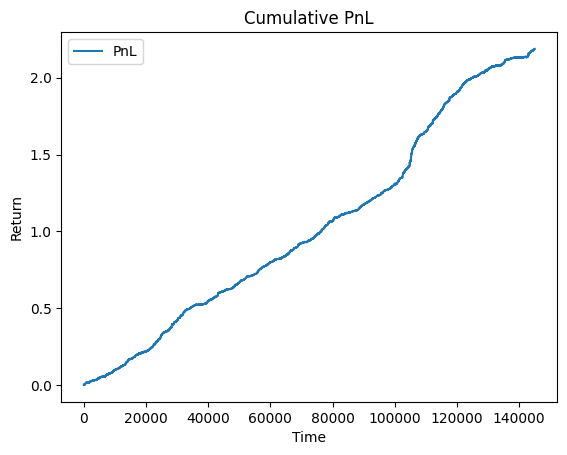

Sharpe Ratio for the epoch: 27.0256
Average Weights:



,Weight
Cash,7.389876e-01
BKNG,8.887545e-02
FICO,6.455663e-02
AZO,5.116518e-02
NVR,2.489018e-02
...,...
LYB,6.979863e-14
DOW,5.743815e-14
ROST,5.601284e-14
ALB,5.155439e-14


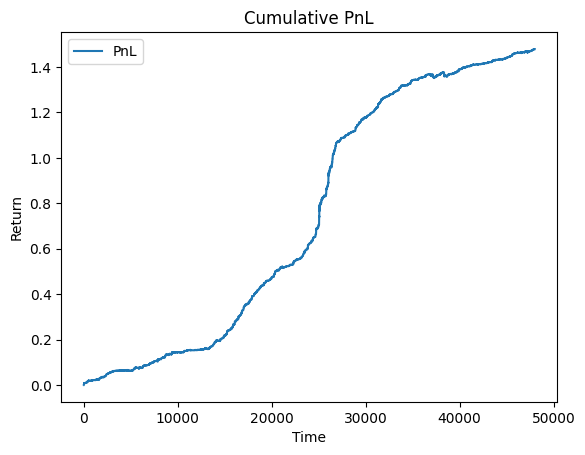

  5%|▍         | 49/1000 [46:34<15:26:04, 58.43s/it]

Sharpe Ratio for the epoch: 31.6496
Average Weights:



,Weight
Cash,7.585218e-01
BKNG,7.805957e-02
FICO,3.606325e-02
NVR,3.594338e-02
AZO,3.230485e-02
...,...
LYB,2.176591e-14
DOW,1.763693e-14
ROST,1.724063e-14
ALB,1.582259e-14


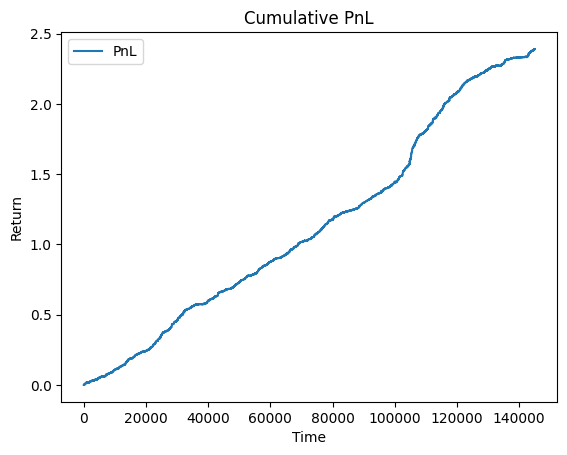

Sharpe Ratio for the epoch: 27.5746
Average Weights:



,Weight
Cash,7.264488e-01
BKNG,9.186443e-02
FICO,6.829123e-02
AZO,5.474085e-02
NVR,2.556352e-02
...,...
LYB,1.710961e-14
DOW,1.387605e-14
ROST,1.350945e-14
ALB,1.235924e-14


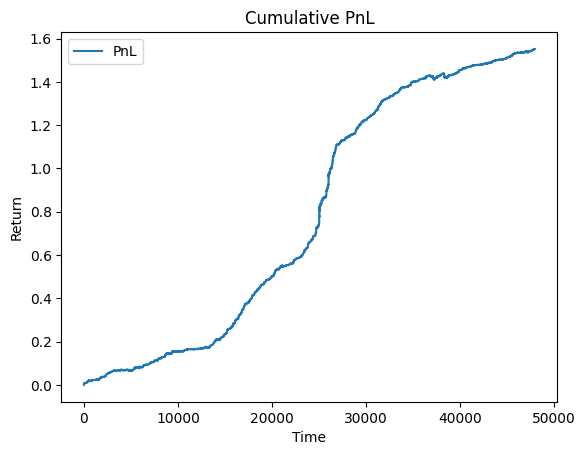

  6%|▌         | 59/1000 [54:58<13:19:53, 51.00s/it]

Sharpe Ratio for the epoch: 32.3607
Average Weights:



,Weight
Cash,7.478175e-01
BKNG,8.134270e-02
NVR,3.827993e-02
FICO,3.747549e-02
AZO,3.392595e-02
...,...
LYB,6.924105e-15
DOW,5.542309e-15
ROST,5.410918e-15
ALB,4.941262e-15


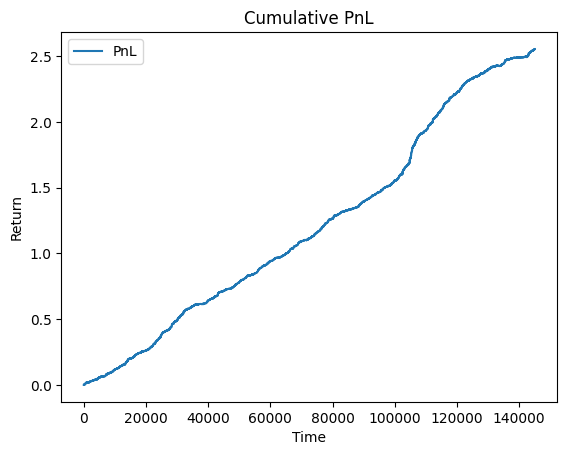

Sharpe Ratio for the epoch: 27.9153
Average Weights:



,Weight
Cash,7.171602e-01
BKNG,9.474181e-02
FICO,7.042948e-02
AZO,5.738165e-02
NVR,2.606798e-02
...,...
LYB,5.457363e-15
DOW,4.372848e-15
ROST,4.251473e-15
ALB,3.870041e-15


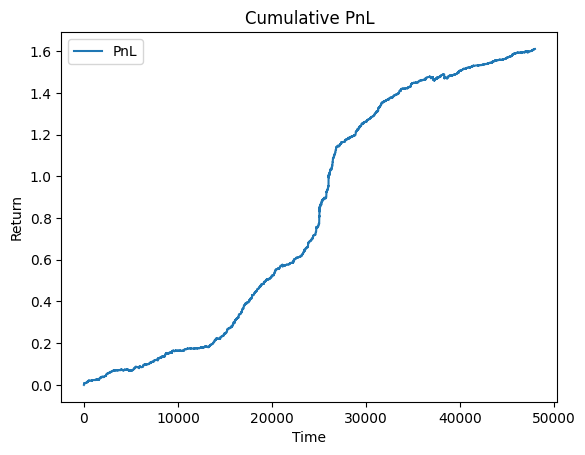

  7%|▋         | 69/1000 [1:04:13<15:00:44, 58.05s/it]

Sharpe Ratio for the epoch: 32.9167
Average Weights:



,Weight
Cash,7.397119e-01
BKNG,8.394524e-02
NVR,4.006898e-02
FICO,3.846810e-02
AZO,3.511834e-02
...,...
LYB,2.624283e-15
DOW,2.078617e-15
ROST,2.027126e-15
ALB,1.843296e-15


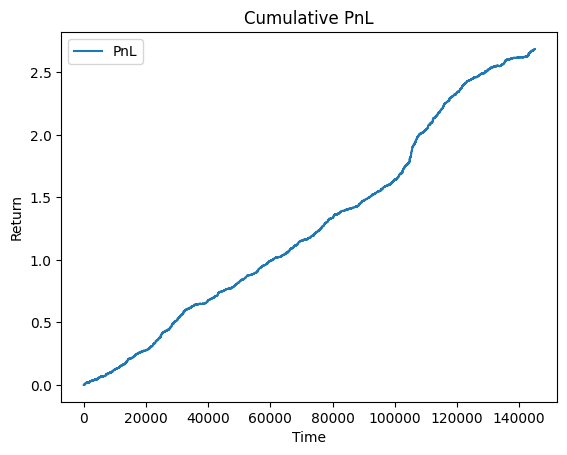

Sharpe Ratio for the epoch: 28.1758
Average Weights:



,Weight
Cash,7.099552e-01
BKNG,9.756867e-02
FICO,7.151863e-02
AZO,5.941444e-02
NVR,2.648713e-02
...,...
LYB,2.071919e-15
DOW,1.643035e-15
ROST,1.595524e-15
ALB,1.446117e-15


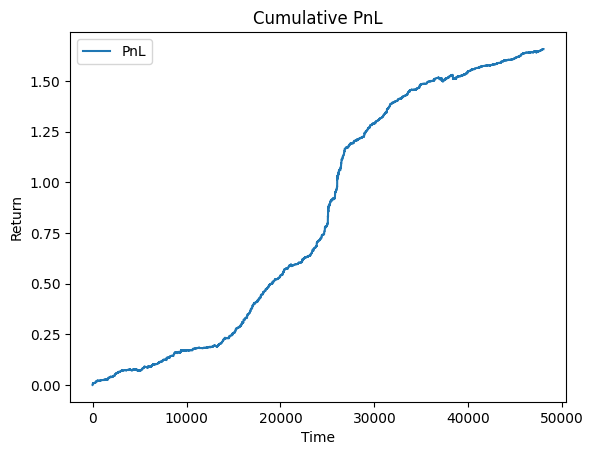

  8%|▊         | 79/1000 [1:13:59<14:00:36, 54.76s/it]

Sharpe Ratio for the epoch: 33.3738
Average Weights:



,Weight
Cash,7.333372e-01
BKNG,8.605251e-02
NVR,4.149012e-02
FICO,3.918179e-02
AZO,3.599782e-02
...,...
LYB,1.126543e-15
DOW,8.840798e-16
ROST,8.613488e-16
ALB,7.802979e-16


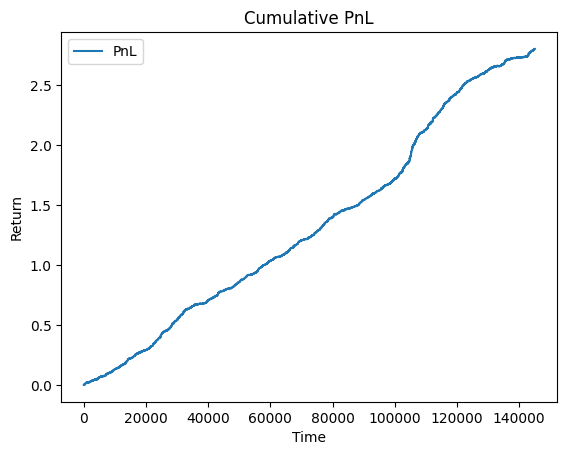

Sharpe Ratio for the epoch: 28.4202
Average Weights:



,Weight
Cash,7.041770e-01
BKNG,1.002372e-01
FICO,7.195211e-02
AZO,6.103180e-02
NVR,2.685299e-02
...,...
LYB,8.904297e-16
DOW,6.996798e-16
ROST,6.787260e-16
ALB,6.128265e-16


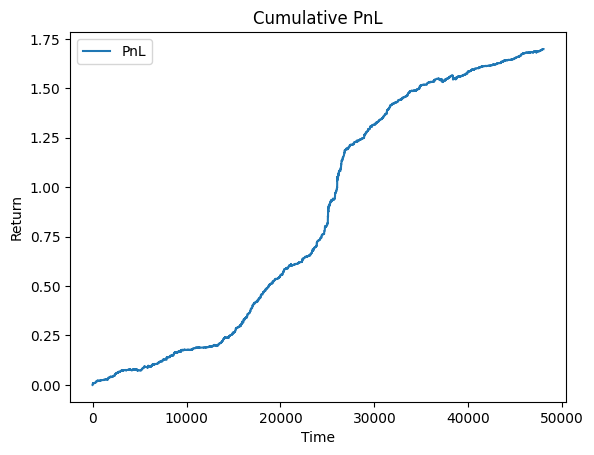

  9%|▉         | 89/1000 [1:23:01<13:40:00, 54.01s/it]

Sharpe Ratio for the epoch: 33.7609
Average Weights:



,Weight
Cash,7.283165e-01
BKNG,8.774535e-02
NVR,4.262808e-02
FICO,3.969151e-02
AZO,3.663998e-02
...,...
LYB,5.310560e-16
DOW,4.133126e-16
ROST,4.023368e-16
ALB,3.632502e-16


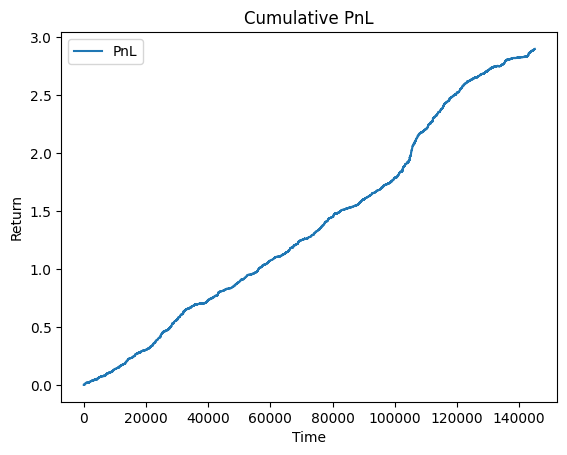

Sharpe Ratio for the epoch: 28.6577
Average Weights:



,Weight
Cash,6.993649e-01
BKNG,1.026945e-01
FICO,7.201947e-02
AZO,6.236371e-02
NVR,2.717169e-02
...,...
LYB,4.201423e-16
DOW,3.274372e-16
ROST,3.173262e-16
ALB,2.855344e-16


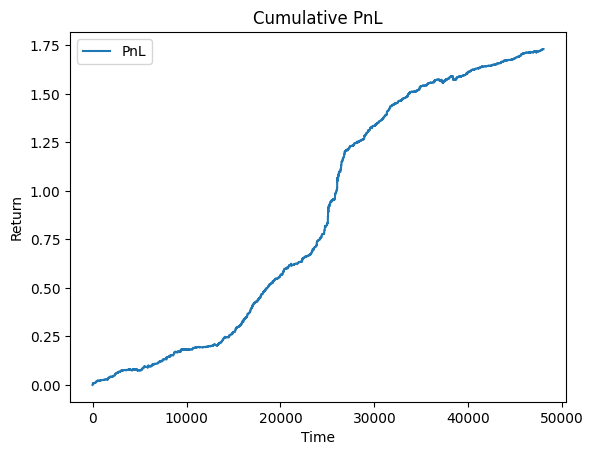

 10%|▉         | 99/1000 [1:32:11<14:00:55, 56.00s/it]

Sharpe Ratio for the epoch: 34.0955
Average Weights:



,Weight
Cash,7.243074e-01
BKNG,8.911435e-02
NVR,4.355253e-02
FICO,4.005930e-02
AZO,3.712060e-02
...,...
LYB,2.699814e-16
DOW,2.085475e-16
ROST,2.028497e-16
ALB,1.825839e-16


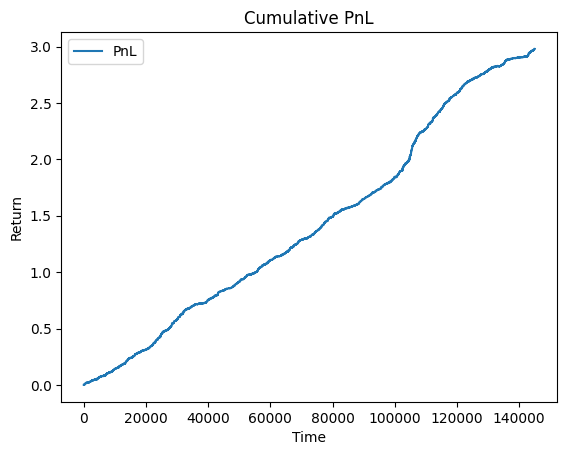

Sharpe Ratio for the epoch: 28.8791
Average Weights:



,Weight
Cash,6.952382e-01
BKNG,1.048756e-01
FICO,7.198834e-02
AZO,6.349342e-02
NVR,2.744034e-02
...,...
LYB,2.137490e-16
DOW,1.653483e-16
ROST,1.601021e-16
ALB,1.436137e-16


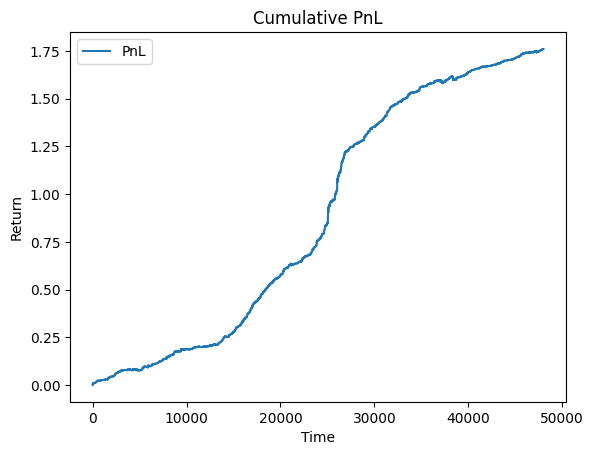

 11%|█         | 109/1000 [1:41:41<14:04:59, 56.90s/it]

Sharpe Ratio for the epoch: 34.3888
Average Weights:



,Weight
Cash,7.210179e-01
BKNG,9.025103e-02
NVR,4.431626e-02
FICO,4.033581e-02
AZO,3.750125e-02
...,...
LYB,1.460285e-16
DOW,1.120271e-16
ROST,1.088879e-16
ALB,9.773580e-17


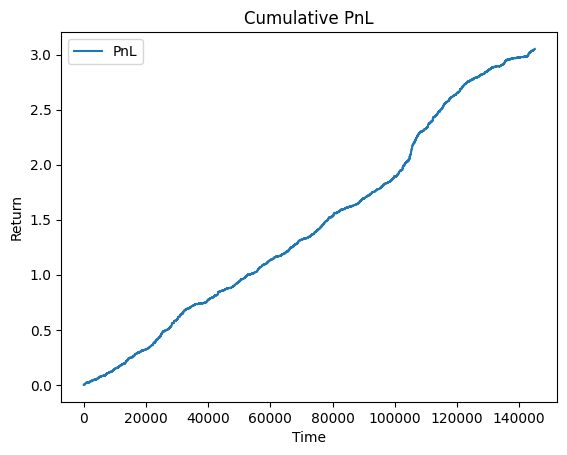

Sharpe Ratio for the epoch: 29.0663
Average Weights:



,Weight
Cash,6.915352e-01
BKNG,1.067370e-01
FICO,7.204402e-02
AZO,6.453708e-02
NVR,2.766095e-02
...,...
LYB,1.156749e-16
DOW,8.887388e-17
ROST,8.598465e-17
ALB,7.690949e-17


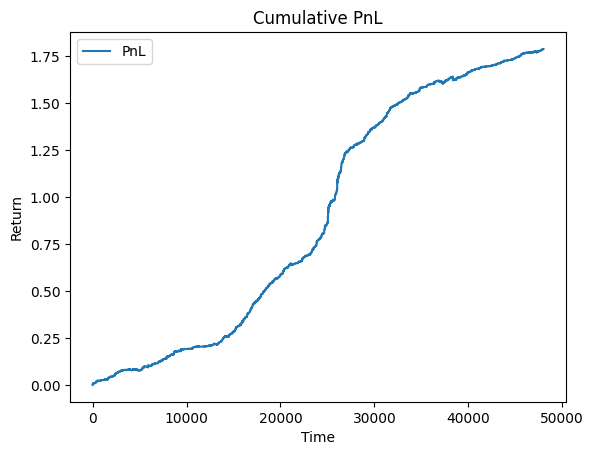

 12%|█▏        | 119/1000 [1:50:45<13:24:14, 54.77s/it]

Sharpe Ratio for the epoch: 34.6467
Average Weights:



,Weight
Cash,7.182886e-01
BKNG,9.119701e-02
NVR,4.495335e-02
FICO,4.055946e-02
AZO,3.782171e-02
...,...
LYB,8.322714e-17
DOW,6.344622e-17
ROST,6.162755e-17
ALB,5.517381e-17


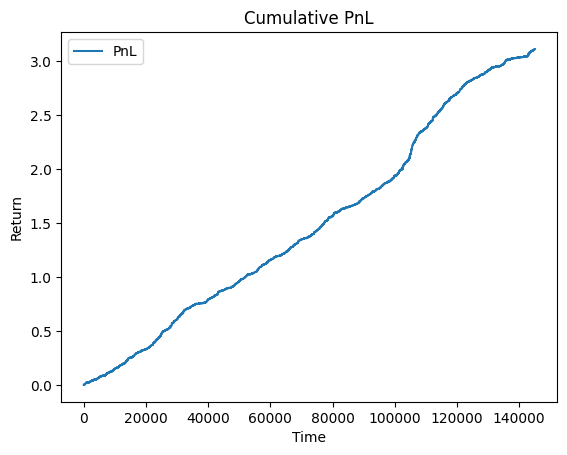

Sharpe Ratio for the epoch: 29.2181
Average Weights:



,Weight
Cash,6.881909e-01
BKNG,1.083011e-01
FICO,7.221463e-02
AZO,6.554612e-02
NVR,2.782409e-02
...,...
LYB,6.595090e-17
DOW,5.035385e-17
ROST,4.868059e-17
ALB,4.342830e-17


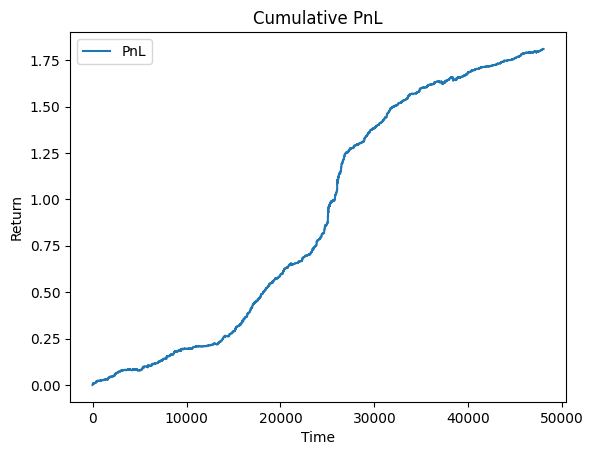

 13%|█▎        | 129/1000 [1:59:52<12:47:07, 52.84s/it]

Sharpe Ratio for the epoch: 34.8761
Average Weights:



,Weight
Cash,7.160054e-01
BKNG,9.198643e-02
NVR,4.548638e-02
FICO,4.075146e-02
AZO,3.809435e-02
...,...
LYB,4.963109e-17
DOW,3.761511e-17
ROST,3.651457e-17
ALB,3.261330e-17


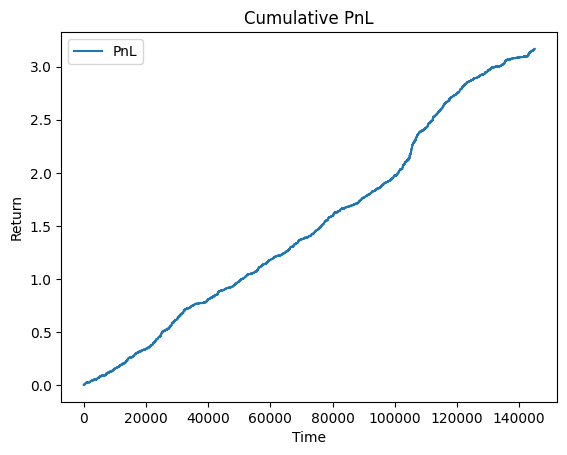

Sharpe Ratio for the epoch: 29.3444
Average Weights:



,Weight
Cash,6.852570e-01
BKNG,1.096117e-01
FICO,7.247833e-02
AZO,6.647772e-02
NVR,2.791787e-02
...,...
LYB,3.933812e-17
DOW,2.986159e-17
ROST,2.884938e-17
ALB,2.567433e-17


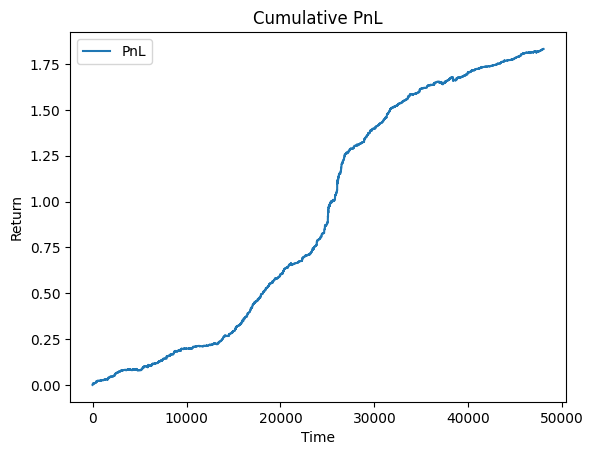

 14%|█▍        | 139/1000 [2:08:38<12:40:00, 52.96s/it]

Sharpe Ratio for the epoch: 35.0828
Average Weights:



,Weight
Cash,7.140057e-01
BKNG,9.267236e-02
NVR,4.594028e-02
FICO,4.094393e-02
AZO,3.833589e-02
...,...
LYB,3.077758e-17
DOW,2.320046e-17
ROST,2.250890e-17
ALB,2.005988e-17


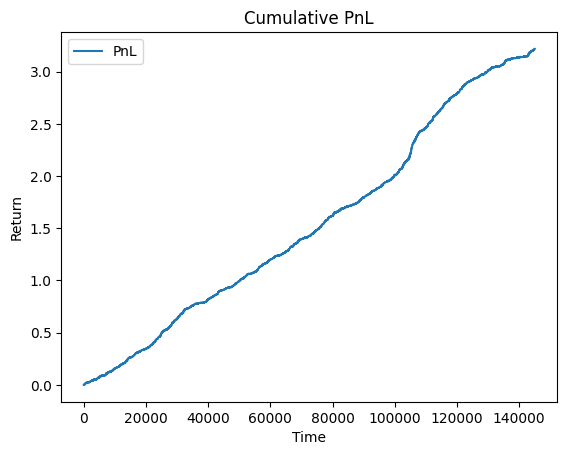

Sharpe Ratio for the epoch: 29.4489
Average Weights:



,Weight
Cash,6.825801e-01
BKNG,1.107269e-01
FICO,7.283778e-02
AZO,6.739630e-02
NVR,2.796340e-02
...,...
LYB,2.439792e-17
DOW,1.842141e-17
ROST,1.778557e-17
ALB,1.579254e-17


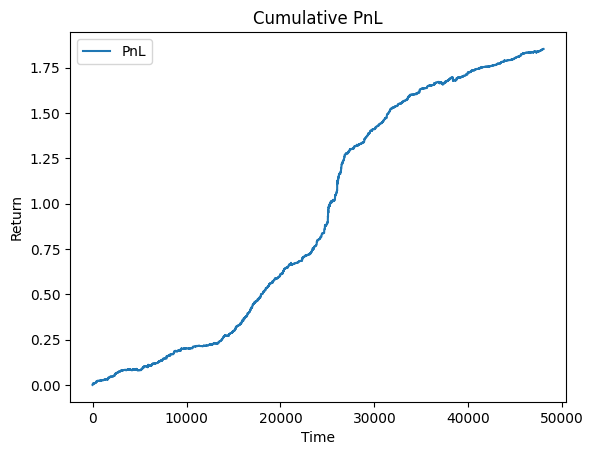

 15%|█▍        | 149/1000 [10:23:54<1462:06:47, 6185.20s/it]

Sharpe Ratio for the epoch: 35.2692
Average Weights:



,Weight
Cash,7.123197e-01
BKNG,9.323799e-02
NVR,4.631874e-02
FICO,4.112466e-02
AZO,3.855150e-02
...,...
LYB,1.975676e-17
DOW,1.481832e-17
ROST,1.436905e-17
ALB,1.277956e-17


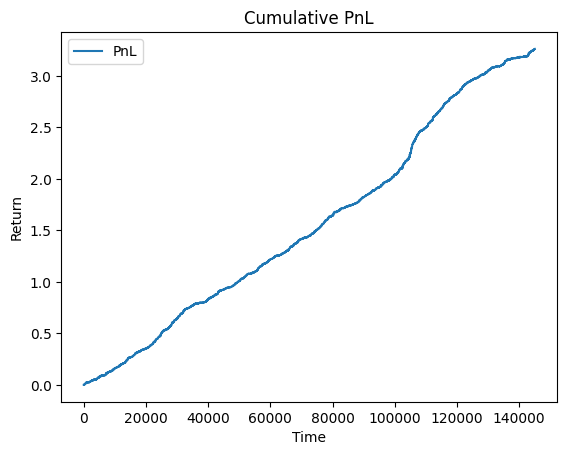

Sharpe Ratio for the epoch: 29.5338
Average Weights:



,Weight
Cash,6.802594e-01
BKNG,1.116804e-01
FICO,7.323421e-02
AZO,6.825611e-02
NVR,2.795579e-02
...,...
LYB,1.566293e-17
DOW,1.176739e-17
ROST,1.135445e-17
ALB,1.006101e-17


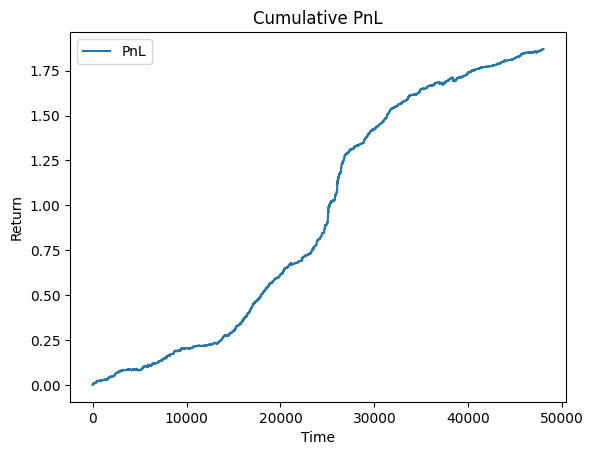

 16%|█▌        | 159/1000 [10:32:29<52:51:41, 226.28s/it]   

Sharpe Ratio for the epoch: 35.4380
Average Weights:



,Weight
Cash,7.108421e-01
BKNG,9.372761e-02
NVR,4.663862e-02
FICO,4.131091e-02
AZO,3.874493e-02
...,...
LYB,1.307984e-17
DOW,9.764683e-18
ROST,9.463988e-18
ALB,8.401121e-18


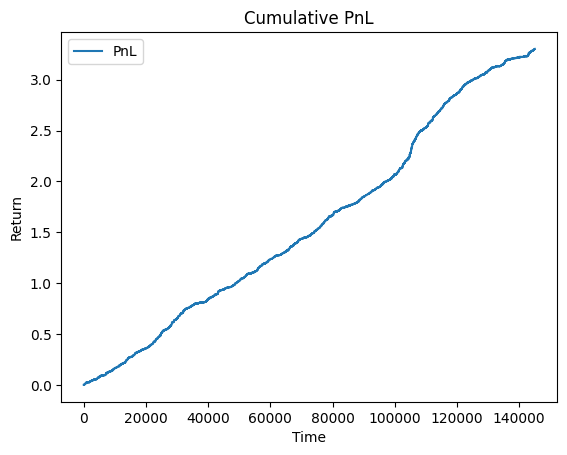

Sharpe Ratio for the epoch: 29.6026
Average Weights:



,Weight
Cash,6.781327e-01
BKNG,1.125942e-01
FICO,7.364870e-02
AZO,6.908108e-02
NVR,2.790305e-02
...,...
LYB,1.037002e-17
DOW,7.754855e-18
ROST,7.478555e-18
ALB,6.613736e-18


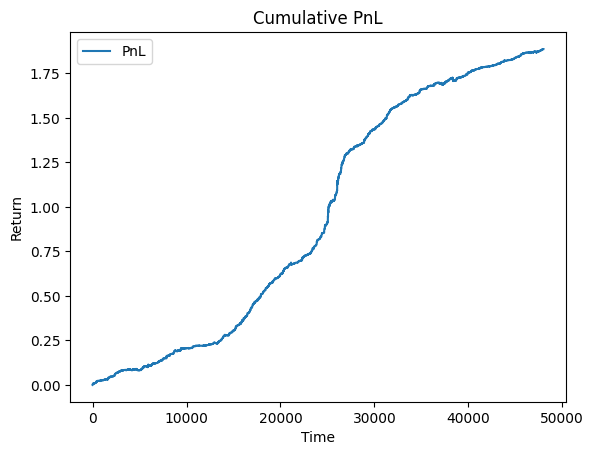

 17%|█▋        | 169/1000 [10:41:07<13:03:51, 56.60s/it] 

Sharpe Ratio for the epoch: 35.5934
Average Weights:



,Weight
Cash,7.095457e-01
BKNG,9.414484e-02
NVR,4.691416e-02
FICO,4.149654e-02
AZO,3.892230e-02
...,...
LYB,8.903133e-18
DOW,6.617730e-18
ROST,6.411014e-18
ALB,5.680958e-18


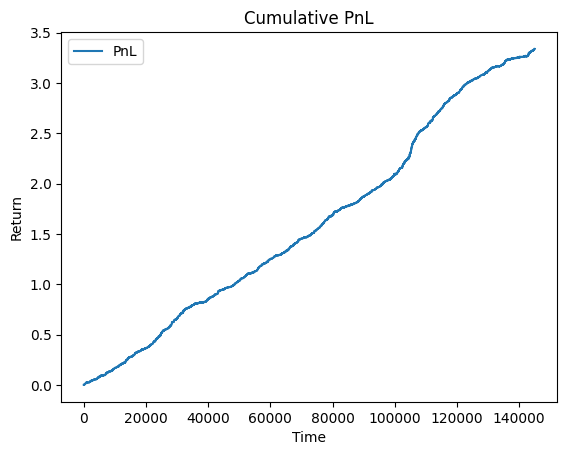

Sharpe Ratio for the epoch: 29.6546
Average Weights:



,Weight
Cash,6.763096e-01
BKNG,1.134329e-01
FICO,7.403834e-02
AZO,6.982896e-02
NVR,2.780416e-02
...,...
LYB,7.058954e-18
DOW,5.256046e-18
ROST,5.066151e-18
ALB,4.472178e-18


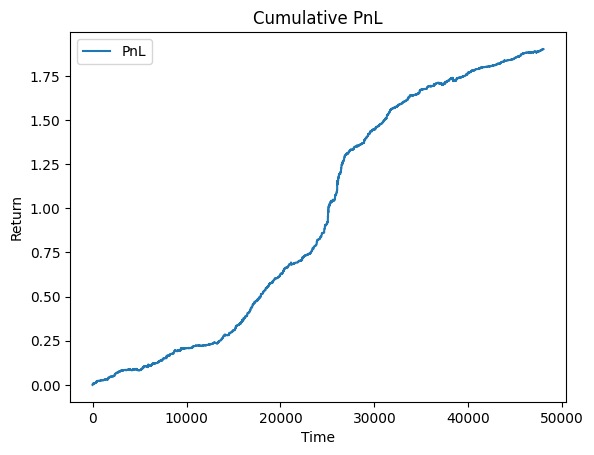

 17%|█▋        | 171/1000 [10:42:56<12:49:46, 55.71s/it]

In [ ]:
batch_size = batch_size_config[0]
pipeline = FeaturesPipeline(
    path_to_data,
    padding=padding,
    batch_size=batch_size,
    split_dates=split_dates,
    split_names=split_names
)

cmf_dim = asset_dim = num_assets = None
for common_feats, asset_feats, fut_ret, _, _ in tqdm(pipeline.iterate('train'), desc="Loading features"):
    cmf_dim = common_feats.shape[1]
    asset_dim = asset_feats.shape[2]
    num_assets = asset_feats.shape[1]
    break

print(f"cmf_dim: {cmf_dim}, asset_dim: {asset_dim}, num_assets: {num_assets}")

model = DeepPortfolioAllocator_1(
    cmf_dim=cmf_dim,
    asset_dim=asset_dim,
    num_assets=num_assets,
)

optimizer = torch.optim.Adam(model.parameters(), lr=adam_lr)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in tqdm(range(num_epochs)):
    if epoch in batch_size_config:
        print(f"Changing batch size to {batch_size_config[epoch]} at epoch {epoch}")
        batch_size = batch_size_config[epoch]
        pipeline = FeaturesPipeline(
            path_to_data,
            padding=padding,
            batch_size=batch_size,
            split_dates=split_dates,
            split_names=split_names
        )

    loss_fn = StreamingSharpeLoss(
        asset_names=pipeline.reader.asset_names + ['Cash'],  # Добавляем Cash в список активов
    )
    loss_fn.reset()
    pipeline.reset()
    for common_feats, asset_feats, fut_ret, min_prices, market_caps in pipeline.iterate('train'):

        # Перевод в тензоры
        common_feats = torch.tensor(common_feats.values, dtype=torch.float32).to(device)       # (T, d_common)
        asset_feats  = torch.tensor(asset_feats,         dtype=torch.float32).to(device)       # (T, n_assets, d_asset)
        fut_ret      = torch.tensor(fut_ret.values,      dtype=torch.float32).to(device)       # (T, n_assets)
        min_prices  = torch.tensor(min_prices.values,   dtype=torch.float32).to(device)       # (T, n_assets)
        market_caps = torch.tensor(market_caps,  dtype=torch.float32).to(device)       # (T, n_assets)

        if len(common_feats) != batch_size:
            continue

        optimizer.zero_grad()

        # Вычисляем веса
        weights = model(common_feats, asset_feats)  # (T, n_assets)
        # Обновляем метрику
        loss_value = loss_fn.forward(
            weights=weights,
            returns=fut_ret,
            min_prices=min_prices,
            market_caps=market_caps
        )
        loss_value.backward()

        optimizer.step()

    if (epoch + 1) % log_freq == 0:
        loss_fn.plot_whole_epoch_loss()  # Выводим Sharpe Ratio за эпоху
    loss_fn.reset()  # Сбрасываем метрику для следующей эпохи

    for common_feats, asset_feats, fut_ret, min_prices, market_caps in pipeline.iterate('test'):
        common_feats = torch.tensor(common_feats.values, dtype=torch.float32).to(device)
        asset_feats  = torch.tensor(asset_feats,         dtype=torch.float32).to(device)
        fut_ret      = torch.tensor(fut_ret.values,      dtype=torch.float32).to(device)
        min_prices  = torch.tensor(min_prices.values,   dtype=torch.float32).to(device)
        market_caps = torch.tensor(market_caps,  dtype=torch.float32).to(device)

        if len(common_feats) != batch_size:
            continue

        weights = model(common_feats, asset_feats)
        loss_fn.forward(weights=weights, returns=fut_ret, min_prices=min_prices, market_caps=market_caps)

    if (epoch + 1) % log_freq == 0:
        loss_fn.plot_whole_epoch_loss()
    loss_fn.reset()